# SETUP: KONFIGURASI PROYEK

In [1]:
import pandas as pd
import ast  # Untuk mengubah string dictionary menjadi dictionary
import matplotlib.pyplot as plt
import seaborn as sns # Library untuk visualisasi yang lebih baik
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

# --- KONFIGURASI PROYEK ---
NAMA_FILE = 'SEntFiN-v1.1.csv'
RANDOM_STATE = 42
MAX_LENGTH = None

# TAHAP 1: EKSPLORASI DATA

Berhasil memuat SEntFiN-v1.1.csv (10753 baris).

--- 1.0: Data Teratas (Head) ---
   S No.                                              Title  \
0      1  SpiceJet to issue 6.4 crore warrants to promoters   
1      2                  MMTC Q2 net loss at Rs 10.4 crore   
2      3  Mid-cap funds can deliver more, stay put: Experts   
3      4             Mid caps now turn into market darlings   
4      5  Market seeing patience, if not conviction: Pra...   

                       Decisions  Words  
0        {"SpiceJet": "neutral"}      8  
1            {"MMTC": "neutral"}      8  
2  {"Mid-cap funds": "positive"}      8  
3       {"Mid caps": "positive"}      7  
4          {"Market": "neutral"}      8  


--- 1.0: Tipe Data Kolom (Info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10753 entries, 0 to 10752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S No.      10753 non-null  int64 
 1   Title      10753 no

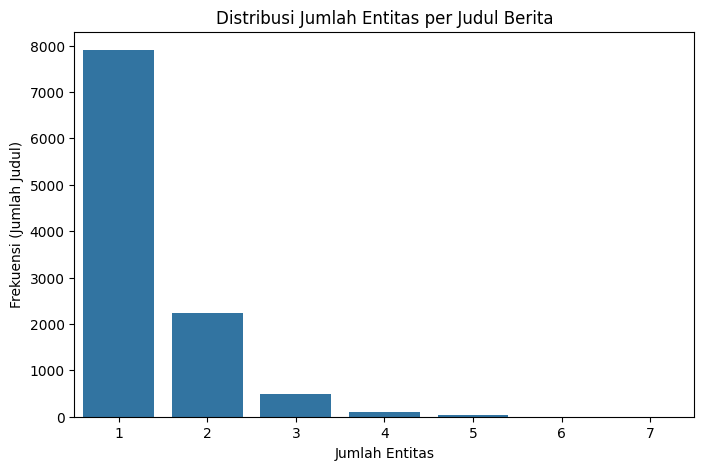

KESIMPULAN:
1. Rata-rata 1.34 entitas per berita.
2. Maksimum 7 entitas dalam 1 berita.

--- 1.2: Analisis Distribusi Label ---
Total label setelah di-flatten: 14409
Distribusi:
Counter({'neutral': 5515, 'positive': 5075, 'negative': 3819})


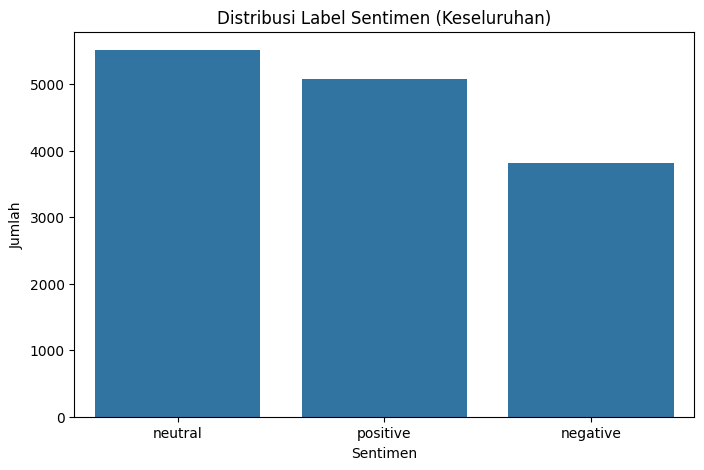


--- 1.3: Analisis Entitas Teratas ---
Entitas paling sering muncul (Top 10):
[('Nifty', 421), ('Sebi', 320), ('Sensex', 281), ('Infosys', 131), ('Gold', 123), ('BSE', 106), ('Rupee', 92), ('RBI', 88), ('rupee', 84), ('gold', 83)]


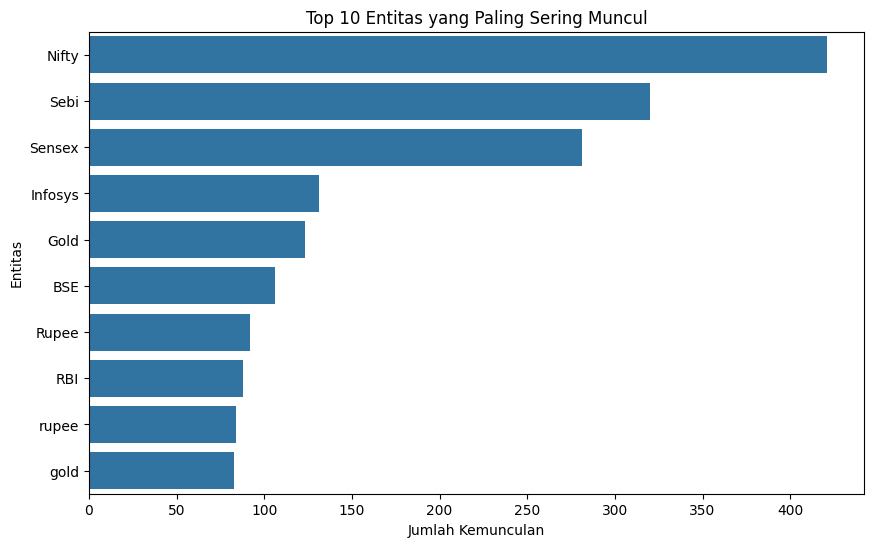


--- 1.4: Analisis Panjang Teks (Mencari MAX_LENGTH) ---
Memuat tokenizer RoBERTa untuk menghitung panjang token...

Statistik Panjang Token:
count    10686.000000
mean        16.593393
std          4.215957
min          7.000000
50%         16.000000
95%         24.000000
99%         28.000000
max         39.000000
dtype: float64

Panjang token MAKSIMUM aktual di dataset: 39
Panjang token 99% data: 28


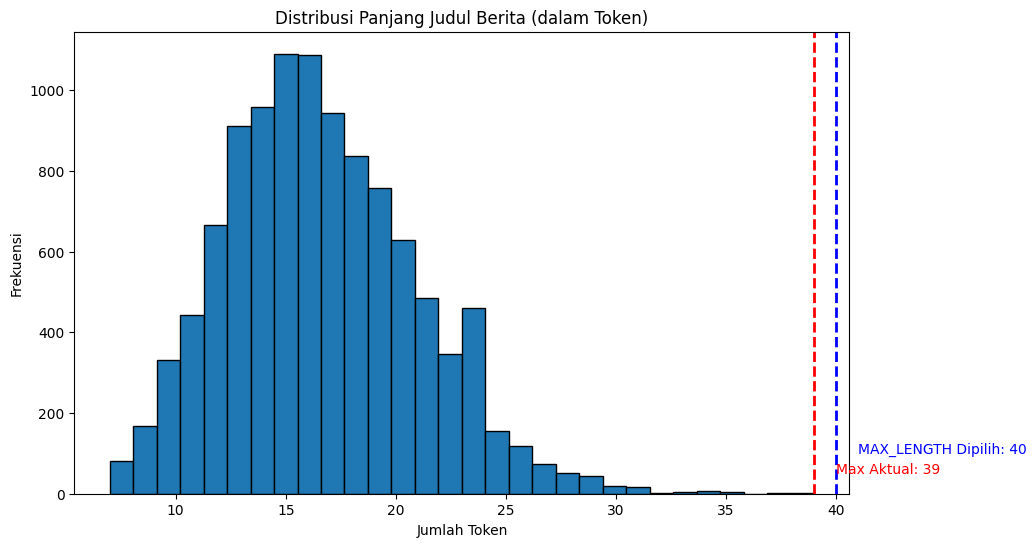

KESIMPULAN: MAX_LENGTH ditetapkan ke 40.


In [2]:
try:
  df = pd.read_csv(NAMA_FILE)
  print(f"Berhasil memuat {NAMA_FILE} ({len(df)} baris).\n")

  # --- 1.0: Melihat Data Mentah ---
  print("--- 1.0: Data Teratas (Head) ---")
  print(df.head())
  print("\n")

  print("--- 1.0: Tipe Data Kolom (Info) ---")
  df.info()
  print("Parsing kolom 'Decisions' (string -> dictionary)...")
  print("\n")

  try:
      df['Decisions_dict'] = df['Decisions'].apply(ast.literal_eval)
  except Exception as e:
      print(f"Error: Gagal parsing kolom 'Decisions'. Error: {e}")
      exit()

  # --- 1.1: Analisis Distribusi Jumlah Entitas per Berita ---
  print("--- 1.1: Analisis Jumlah Entitas per Berita ---")
  df['num_entities'] = df['Decisions_dict'].apply(len)

  print(df['num_entities'].describe())

  plt.figure(figsize=(8, 5))
  sns.countplot(x=df['num_entities'])
  plt.title('Distribusi Jumlah Entitas per Judul Berita')
  plt.xlabel('Jumlah Entitas')
  plt.ylabel('Frekuensi (Jumlah Judul)')
  plt.show()

  print(f"KESIMPULAN:\n1. Rata-rata {df['num_entities'].mean():.2f} entitas per berita.")
  print(f"2. Maksimum {df['num_entities'].max()} entitas dalam 1 berita.")

  # --- 1.2: Analisis Distribusi Label Sentimen ---
  print("\n--- 1.2: Analisis Distribusi Label ---")
  all_labels = [label for decisions in df['Decisions_dict'] for label in decisions.values()]
  label_counts = Counter(all_labels)

  print(f"Total label setelah di-flatten: {len(all_labels)}")
  print(f"Distribusi:\n{label_counts}")

  # Cek class imbalance
  if label_counts['neutral'] > (label_counts['positive'] + label_counts['negative']):
      print("KESIMPULAN: Data 'imbalanced'. Kita perlu 'Weighted Loss' & 'Macro F1'.")

  df_labels = pd.DataFrame(label_counts.items(), columns=['Label', 'Jumlah'])
  plt.figure(figsize=(8, 5))
  sns.barplot(data=df_labels, x='Label', y='Jumlah')
  plt.title('Distribusi Label Sentimen (Keseluruhan)')
  plt.xlabel('Sentimen')
  plt.ylabel('Jumlah')
  plt.show()

  # --- 1.3: Analisis Entitas Teratas ---
  print("\n--- 1.3: Analisis Entitas Teratas ---")
  all_entities = [entity for decisions in df['Decisions_dict'] for entity in decisions.keys()]
  entity_counts = Counter(all_entities)
  print("Entitas paling sering muncul (Top 10):")
  print(entity_counts.most_common(10))

  df_entities = pd.DataFrame(entity_counts.most_common(10), columns=['Entitas', 'Jumlah'])
  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_entities, y='Entitas', x='Jumlah', orient='h')
  plt.title('Top 10 Entitas yang Paling Sering Muncul')
  plt.xlabel('Jumlah Kemunculan')
  plt.ylabel('Entitas')
  plt.show()

  # --- 1.4: Analisis Panjang Teks (Mencari MAX_LENGTH) ---
  print("\n--- 1.4: Analisis Panjang Teks (Mencari MAX_LENGTH) ---")
  print("Memuat tokenizer RoBERTa untuk menghitung panjang token...")
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

  unique_titles = df['Title'].unique()
  token_lengths = [len(tokenizer.encode(title)) for title in unique_titles]
  lengths_series = pd.Series(token_lengths)

  print("\nStatistik Panjang Token:")
  print(lengths_series.describe(percentiles=[0.95, 0.99]))

  plt.figure(figsize=(10, 6))
  plt.hist(lengths_series, bins=30, edgecolor='k')
  plt.title('Distribusi Panjang Judul Berita (dalam Token)')
  plt.xlabel('Jumlah Token')
  plt.ylabel('Frekuensi')

  # --- PENENTUAN MAX_LENGTH SECARA OTOMATIS ---
  max_actual = lengths_series.max()
  persentil_99 = int(lengths_series.quantile(0.99))

  print(f"\nPanjang token MAKSIMUM aktual di dataset: {max_actual}")
  print(f"Panjang token 99% data: {persentil_99}")

  # MAX_LENGTH: max aktual dan bulatkan ke kelipatan 8 terdekat
  if max_actual % 8 == 0:
    MAX_LENGTH = max_actual
  else:
    MAX_LENGTH = max_actual + (8 - max_actual % 8)

  plt.axvline(max_actual, color='red', linestyle='dashed', linewidth=2)
  plt.text(max_actual + 1, 50, f'Max Aktual: {max_actual}', color='red')
  plt.axvline(MAX_LENGTH, color='blue', linestyle='dashed', linewidth=2)
  plt.text(MAX_LENGTH + 1, 100, f'MAX_LENGTH Dipilih: {MAX_LENGTH}', color='blue')
  plt.show()

  print(f"KESIMPULAN: MAX_LENGTH ditetapkan ke {MAX_LENGTH}.")

except FileNotFoundError:
  print(f"ERROR: File '{NAMA_FILE}' tidak ditemukan.")
  exit()

# TAHAP 2: DATA SPLITTING

In [3]:
print("Melakukan split data 80/20 berdasarkan 'Judul Unik' (Anti-Leakage)...")

unique_titles = df['Title'].unique()
train_titles, test_titles = train_test_split(
  unique_titles,
  test_size=0.2,
  random_state=RANDOM_STATE
)
train_df = df[df['Title'].isin(train_titles)]
test_df = df[df['Title'].isin(test_titles)]

print(f"Judul unik untuk latih: {len(train_titles)}")
print(f"Judul unik untuk uji: {len(test_titles)}")

Melakukan split data 80/20 berdasarkan 'Judul Unik' (Anti-Leakage)...
Judul unik untuk latih: 8548
Judul unik untuk uji: 2138


# TAHAP 3: FLATTENING

In [4]:
def flatten_dataset(dataframe):
    flattened_data = []
    for _, row in dataframe.iterrows():
        sentence = row['Title']
        decisions = row['Decisions_dict']
        for entity, label in decisions.items():
            flattened_data.append({
                'entity': entity,
                'sentence': sentence,
                'label': label
            })
    return pd.DataFrame(flattened_data)

train_flat = flatten_dataset(train_df)
test_flat = flatten_dataset(test_df)

print(f"Data latih (flat) dibuat: {len(train_flat)} baris")
print(f"Data uji (flat) dibuat: {len(test_flat)} baris")
print("\nContoh data latih yang sudah di-flatten:")
print(train_flat.head())

Data latih (flat) dibuat: 11493 baris
Data uji (flat) dibuat: 2916 baris

Contoh data latih yang sudah di-flatten:
          entity                                           sentence     label
0           MMTC                  MMTC Q2 net loss at Rs 10.4 crore   neutral
1  Mid-cap funds  Mid-cap funds can deliver more, stay put: Experts  positive
2         Market  Market seeing patience, if not conviction: Pra...   neutral
3        Infosys    Infosys: Will the strong volume growth sustain?   neutral
4          Hudco          Hudco raises Rs 279 cr via tax-free bonds  positive


# TAHAP 4: PREPROCESSING

In [5]:
# --- 4.1: Label Encoding ---
print("\n--- 4.1: Label Encoding ---")
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label2id.items()}

train_flat['label_id'] = train_flat['label'].map(label2id)
test_flat['label_id'] = test_flat['label'].map(label2id)

print("Label 'positive', 'negative', 'neutral' telah diubah menjadi 0, 1, 2.")
print(train_flat[['entity', 'label', 'label_id']].head())

# --- 4.2: Tokenisasi ABSA (Demonstrasi) ---
print("\n--- 4.2: Tokenisasi ABSA (Demonstrasi) ---")
print(f"Demonstrasi tokenisasi menggunakan MAX_LENGTH = {MAX_LENGTH} (ditemukan di Tahap 1)")

try:
    contoh = train_flat.iloc[0]
    contoh_entity = contoh['entity']
    contoh_sentence = contoh['sentence']

    print(f"\nContoh Entity:   {contoh_entity}")
    print(f"Contoh Sentence: {contoh_sentence}")

    encoded_input = tokenizer(
        contoh_entity,
        contoh_sentence,
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,  # <-- Menggunakan nilai yang ditemukan di TAHAP 1
        return_tensors='pt'
    )

    print("\nHasil Tokenisasi (Input untuk Model):")
    print(encoded_input['input_ids'])

    print("\nFormat Teks (untuk manusia):")
    print(tokenizer.decode(encoded_input['input_ids'][0]))

except IndexError:
    print("Error: DataFrame latih kosong, tidak bisa mengambil sampel.")


--- 4.1: Label Encoding ---
Label 'positive', 'negative', 'neutral' telah diubah menjadi 0, 1, 2.
          entity     label  label_id
0           MMTC   neutral         1
1  Mid-cap funds  positive         2
2         Market   neutral         1
3        Infosys   neutral         1
4          Hudco  positive         2

--- 4.2: Tokenisasi ABSA (Demonstrasi) ---
Demonstrasi tokenisasi menggunakan MAX_LENGTH = 40 (ditemukan di Tahap 1)

Contoh Entity:   MMTC
Contoh Sentence: MMTC Q2 net loss at Rs 10.4 crore

Hasil Tokenisasi (Input untuk Model):
tensor([[    0, 16261,  6078,     2,     2, 16261,  6078,  1209,   176,  1161,
           872,    23,  2144,   158,     4,   306,  4963,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]])

Format Teks (untuk manusia):
<s>MMTC</s></s>MMTC Q2 net loss at Rs 10.4 crore</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

# TAHAP 5: PEMODELAN DENGAN RoBERTa

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaModel, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# --- 5.1: Setup Device (GPU/CPU) ---
print("--- 5.1: Setup Device ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device yang digunakan: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# --- 5.2: Hitung Class Weights untuk Weighted Loss ---
print("\n--- 5.2: Menghitung Class Weights ---")
from sklearn.utils.class_weight import compute_class_weight

# Hitung class weights dari training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=train_flat['label_id'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights (untuk mengatasi imbalance):")
print(f"  - Negative (0): {class_weights[0]:.4f}")
print(f"  - Neutral  (1): {class_weights[1]:.4f}")
print(f"  - Positive (2): {class_weights[2]:.4f}")

print("\nKESIMPULAN: Class weights akan membuat model lebih fokus pada kelas minoritas.")

ImportError: cannot import name 'AdamW' from 'transformers' (/Users/ikrargempurtirani/NLP/PROJECT-ABSA/venv/lib/python3.14/site-packages/transformers/__init__.py)

In [ ]:
# --- 5.3: Definisi Model RoBERTa untuk ABSA ---
print("\n--- 5.3: Definisi Model RoBERTa untuk ABSA ---")

class RobertaForABSA(nn.Module):
    def __init__(self, num_labels=3, dropout_rate=0.1):
        super(RobertaForABSA, self).__init__()
        # Load pre-trained RoBERTa
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout_rate)
        # Classification head
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        # Get RoBERTa outputs
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use [CLS] token representation (pooled output)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Classification
        logits = self.classifier(pooled_output)
        return logits

print("Model RoBERTa untuk ABSA telah didefinisikan.")
print("Arsitektur:")
print("  1. RoBERTa Base (12 layers, 768 hidden size)")
print("  2. Dropout (0.1)")
print("  3. Linear Classifier (768 -> 3 classes)")

In [ ]:
# --- 5.4: Inisialisasi Model, Loss Function, dan Optimizer ---
print("\n--- 5.4: Inisialisasi Model & Optimizer ---")

# Inisialisasi model
model = RobertaForABSA(num_labels=3, dropout_rate=0.1)
model = model.to(device)

# Hitung jumlah parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function dengan class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"\nLoss Function: CrossEntropyLoss dengan class weights")

# Optimizer: AdamW dengan learning rate 2e-5
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
print(f"Optimizer: AdamW (lr={learning_rate}, eps=1e-8)")

print("\nKESIMPULAN: Model, loss function, dan optimizer siap untuk training!")

# TAHAP 6: FINE-TUNING

In [ ]:
# --- 6.1: Membuat PyTorch Dataset ---
print("--- 6.1: Membuat PyTorch Dataset ---")

class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        entity = self.data.loc[idx, 'entity']
        sentence = self.data.loc[idx, 'sentence']
        label = self.data.loc[idx, 'label_id']
        
        # Tokenisasi
        encoding = self.tokenizer(
            entity,
            sentence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Buat dataset
train_dataset = ABSADataset(train_flat, tokenizer, MAX_LENGTH)
test_dataset = ABSADataset(test_flat, tokenizer, MAX_LENGTH)

print(f"Training dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

In [ ]:
# --- 6.2: Membuat DataLoader ---
print("\n--- 6.2: Membuat DataLoader ---")

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 untuk menghindari multiprocessing issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# --- 6.3: Setup Learning Rate Scheduler ---
print("\n--- 6.3: Setup Learning Rate Scheduler ---")

NUM_EPOCHS = 5
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")
print(f"Epochs: {NUM_EPOCHS}")
print("\nScheduler: Linear warmup + linear decay")

In [ ]:
# --- 6.4: Fungsi Training dan Evaluation ---
print("\n--- 6.4: Definisi Fungsi Training & Evaluation ---")

def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    """Training untuk 1 epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Track metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')
    
    return avg_loss, accuracy, f1_macro


def evaluate(model, data_loader, criterion, device):
    """Evaluasi model"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Evaluating')
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')
    
    return avg_loss, accuracy, f1_macro, predictions, true_labels

print("Fungsi training dan evaluation telah didefinisikan.")

In [ ]:
# --- 6.5: Training Loop dengan Early Stopping ---
print("\n--- 6.5: Training Loop dengan Early Stopping ---")

# Early stopping parameters
PATIENCE = 3
best_f1 = 0
patience_counter = 0
best_model_state = None

# Tracking metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

print(f"Memulai training untuk {NUM_EPOCHS} epochs...")
print(f"Early stopping patience: {PATIENCE} epochs")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*80}")
    
    # Training
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device
    )
    
    # Validation
    val_loss, val_acc, val_f1, _, _ = evaluate(
        model, test_loader, criterion, device
    )
    
    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print epoch results
    print(f"\n{'='*80}")
    print(f"HASIL EPOCH {epoch + 1}:")
    print(f"  Training   -> Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1-Macro: {train_f1:.4f}")
    print(f"  Validation -> Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1-Macro: {val_f1:.4f}")
    print(f"{'='*80}")
    
    # Early stopping check
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"✓ New best F1-Macro: {best_f1:.4f} - Model saved!")
    else:
        patience_counter += 1
        print(f"✗ No improvement. Patience: {patience_counter}/{PATIENCE}")
        
        if patience_counter >= PATIENCE:
            print(f"\n{'='*80}")
            print(f"Early stopping triggered! Best F1-Macro: {best_f1:.4f}")
            print(f"{'='*80}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ Best model loaded (F1-Macro: {best_f1:.4f})")

In [ ]:
# --- 6.6: Visualisasi Training History ---
print("\n--- 6.6: Visualisasi Training History ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Accuracy')
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# F1-Macro
axes[2].plot(epochs_range, history['train_f1'], 'b-o', label='Train F1-Macro')
axes[2].plot(epochs_range, history['val_f1'], 'r-o', label='Validation F1-Macro')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1-Macro')
axes[2].set_title('Training & Validation F1-Macro')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Visualisasi training history selesai.")